In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from math import pi

In [2]:
import qcgpu

In [3]:
#Creation and normalization of an array with gaussian probabilities
def gauss(x, mu, sigma):
    dx = x[1]-x[0]
    g = (1/(np.sqrt(2*pi*sigma**2)))*np.exp(-((x-mu)**2)/(2*sigma**2))
    f = g*dx/(np.sum(g * dx))
    return f

In [4]:
#Variational circuit that simulates a quantum random walk of a particle
def RWcircuit(qubits, parameters):
    if qubits%2==0: raise ValueError('Try odd number of qubits')
    C = qcgpu.State(qubits+1)
    mid = int((qubits-1)/2)
    C.x(mid)
    p = 0
    for layer in range(mid):
        #Population distribution to open states
        C.cu(mid-layer, mid-layer-1, parameters[p], 0, 0)
        p += 1
        C.cx(mid-layer-1, mid-layer)
        C.cu(mid+layer, mid+layer+1, parameters[p], 0, 0)
        p += 1
        C.cx(mid+layer+1, mid+layer)
        for i in reversed(range(layer)):
            #Probabilistic SWAPs for already occupied states
            C.cx(mid-i, mid-i-1)
            C.cu(mid-i-1, mid-i, parameters[p], 0, 0)
            p += 1
            C.cx(mid-i, mid-i-1)
            
            C.cx(mid+i, mid+i+1)
            C.cu(mid+i+1, mid+i, parameters[p], 0, 0)
            p += 1
            C.cx(mid+i, mid+i+1)
    return C
    

In [5]:
#Parameter creation for the first step of the variational algorithm
def parameters(qubits):
    a = int((qubits**2 - 2 * qubits + 1)/2)
    p = 2*pi*np.random.random((a,))
    return p

In [6]:
#Cost funtion 
def cost_function(par, qubits, ga):
    circ = RWcircuit(qubits, par)
    cost = 0
    #psi = circ.amplitudes()
    prob = circ.probabilities()
    for i in range(qubits):
        #cost+=((ga[i]) - (np.abs(psi[int(2**i)]))**2)**2
        cost+=((ga[i]) - (prob[int(2**i)]))**2
    return cost

In [7]:
#Probability distribution of the circuit's final state
def result(par, qubits):
    circ = RWcircuit(qubits, par)
    #psi = circ.amplitudes()
    prob = circ.probabilities()
    sol = []
    for i in range(qubits):
        #sol.append(np.abs(psi[int(2**i)])**2)
        sol.append(prob[int(2**i)])
    return np.array(sol)

In [8]:
#Circuit that encodes the pay-off on the ancilla qubit (MSQ)
def PayoffCircuit(qubits, C, K, S):
    for i in range(qubits):
        bK = i
        if K<S[i]:
            break
    #Control-RY rotations controled by states with higher value than strike
    #targeting the ancilla qubit
    for i in range(bK, qubits):
        angle = 2 * np.arcsin(np.sqrt((S[i]-K)/S[qubits-1]))
        C.cu(i, qubits, angle, 0, 0)
    return C

In [9]:
#Classical algorithm to compare the pay-off from a precise gaussian to the quantum result
def Payoff(qubits, K, mu, sigma, C, S):
    #psi = C.amplitudes()
    prob = C.probabilities()
    CPayoff = 0
    Sp = np.linspace(mu-3*sigma, mu+3*sigma, 2**qubits)
    fp = gauss(Sp, mu, sigma)
    for i in range(2**qubits):
        if K<Sp[i]:
            CPayoff += fp[i]*(Sp[i]-K)
    #The quantum pay-off is computed adding the probabilities 
    #of finding the ancilla qubit on the state 1
    QPayoff = 0
    for i in range(2**qubits, 2**(qubits+1)):
        #QPayoff += S[qubits-1]*(np.abs(psi[i])**2)
        QPayoff += S[qubits-1]*(prob[i])
    return CPayoff, QPayoff

In [10]:
from scipy.optimize import minimize

In [11]:
#Minimization methods
'''
'CG' -> not usable for qcgpu
'BFGS' -> not usable for qcgpu
'L-BFGS-B' -> not usable for qcgpu
'SLSQP' -> not usable for qcgpu
'COBYLA' -> for qcgpu only this one works
'''

"\n'CG' -> not usable for qcgpu\n'BFGS' -> not usable for qcgpu\n'L-BFGS-B' -> not usable for qcgpu\n'SLSQP' -> not usable for qcgpu\n'COBYLA' -> for qcgpu only this one works\n"

In [13]:
#Initialize variables used in the computation
qu = 15
S0 = 100
K = 125
sig = 20

S = np.linspace(S0-3*sig, S0+3*sig, qu)
g = gauss(S, S0, sig)
para = parameters(qu)

In [14]:
#Find and record the optimal parameters for the gaussian
solution = minimize(cost_function, para, args=(qu, g), method='COBYLA', options={'disp': True})

Optimization terminated successfully.
         Current function value: 0.444473
         Iterations: 2
         Function evaluations: 120
         Gradient evaluations: 6


In [15]:
optimal_parameters = solution.x

In [36]:
cost = cost_function(optimal_parameters, qu, g)
print(cost)

0.25347093219258815


In [30]:
#Calculate the final probabilities using the optimized parameters
r = result(optimal_parameters, qu)

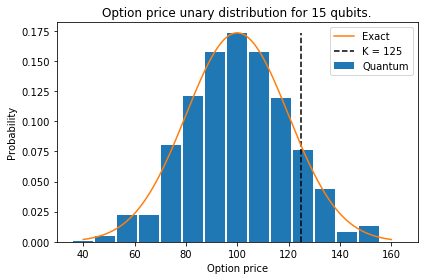

In [31]:
#Plot the probabilities of the circuit against the classical gaussian probabilities
width = (S[1]-S[0])/1.1
Sp = np.linspace(S0-3*sig, S0+3*sig, 2**qu)
fp = gauss(Sp, S0, sig)
fig, ax = plt.subplots()
#rects1 = ax.bar(S-width/2, g, width, label='Exact')
rects2 = ax.bar(S, r, width, label='Quantum')
ax.plot(Sp, max(r)*fp/max(fp), 'C1', label='Exact')

ax.vlines(K, 0, max(r), linestyles='dashed', label='K = {}'.format(K))
plt.ylabel('Probability')
plt.xlabel('Option price')
plt.title('Option price unary distribution for {} qubits.'.format(qu))
ax.legend()


fig.tight_layout()

#savefig('{}qubits_Comparision.png'.format(qu), bbox_inches='tight')

plt.show()

In [32]:
#Run the optmized circuit with the pay-off circuit
C = RWcircuit(qu, optimal_parameters)
C = PayoffCircuit(qu, C, K, S)

In [33]:
#Compute the classical precise pay-off and compare it with the one found quantically
CP, QP = Payoff(qu, K, S0, sig, C, S)

print('With precision {}'.format(2**qu))
print('Classical Pay-off: {}'.format(CP))
print('')
print('With precision {} qubits'.format(qu))
print('Quantum Pay-off: {}'.format(QP))
print('')
print('Percentage off: {}%'.format(np.abs(100*(CP-QP)*2/(CP + QP))))

With precision 32768
Classical Pay-off: 0.9594515865278388

With precision 15 qubits
Quantum Pay-off: 0.9463993143981109

Percentage off: 1.3697054815134315%
